### HFUL estimator function

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import inv

def b_hful(y,X,Z):
    
    # Dimensions
    n = y.shape[0]
    k = X.shape[1]
    
    # Create P matrix
    P = np.dot(Z@inv(Z.T@Z),Z.T)
    
    # Create Xbar matrix
    Xbar = np.column_stack((y,X))
    
    # Get alpha: first create sum term, then matrix, then get eigenvals, then select smallest eigenval (alpha)
    PXbarXbar = Xbar.T @ P @ Xbar
    for i in range(n):
        PXbarXbar -= P[i, i] * np.outer(Xbar[i, :], Xbar[i, :])
    BigMat = inv(Xbar.T@Xbar)@(PXbarXbar)
    
    eigvals = np.linalg.eigvals(BigMat)
    alpha = np.min(eigvals)
    
    # Get alpha hat
    AlphaHat = ((alpha - (1-alpha))/n) / ((1 - (1-alpha))/n)
    
    # Create HFUL estimator: create sum terms, then estimator
    PXX = X.T @ P @ X - AlphaHat * X.T @ X
    PXy = X.T @ P @ y - AlphaHat * X.T @ y
    for i in range(n):
        PXX -= P[i, i] * np.outer(X[i, :], X[i, :])
        PXy -= P[i, i] * X[i, :] * y[i]
        
    bHFUL = inv(PXX) @ (PXy)
    return(bHFUL)

### 2SLS estimator Function (and OLS)

In [2]:
def b_iv(y,X,Z):
    bIV = np.linalg.solve(Z.T@X,Z.T@y)
    return(bIV)

def b_ols(y,X,Z):
    bOLS = np.linalg.solve(X.T@X,X.T@y)
    return(bOLS)

### Monte Carlo - Single instrument

In [3]:
from scipy.stats import distributions as iid
from scipy.stats import multivariate_normal

np.random.seed(1995)
iterations = 5000 # number of simulations
N = 100 # number of obs - want to test finite samples
beta = 1 # true beta value
pi = 0.8 # how strong is the instrument?
gamma = 0.5 # effect of unobserved variable on X
estimates = np.empty((1,3))

for i in range(iterations):
    u = iid.norm().rvs(N)
    v = iid.norm().rvs(N)
    Z = iid.norm().rvs(N) # Z independent, for now one variable
    w = iid.norm().rvs(N) # unobserved 'omitted variable'
    
    constant = np.ones(N) # to add to X and Z
    
    X = Z*pi + gamma*w + v # define X
    Xmat = np.column_stack((constant,X)) # make matrix
    y = X*beta + w + np.multiply(X, u) # define y; X is correlated with u & heteroskedasticity
    Zmat = np.column_stack((constant,Z)) # make Z matrix

    # calculate estimates
    estimate = np.array([b_ols(y,Xmat,Zmat)[1], b_iv(y,Xmat,Zmat)[1], b_hful(y,Xmat,Zmat)[1]])
    estimates = np.vstack((estimates, estimate))

### Estimate Histograms

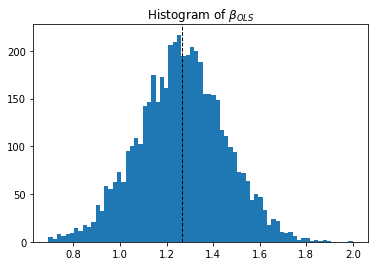

In [4]:
import matplotlib.pyplot as plt
plt.hist(estimates[:, 0], bins=int(np.ceil(np.sqrt(estimates.shape[0]))))
plt.title(r"Histogram of $\beta_{OLS}$")
plt.axvline(estimates[:, 0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

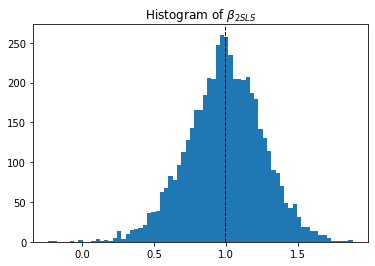

In [5]:
plt.hist(estimates[:, 1], bins=int(np.ceil(np.sqrt(estimates.shape[0]))))
plt.title(r"Histogram of $\beta_{2SLS}$")
plt.axvline(estimates[:, 1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

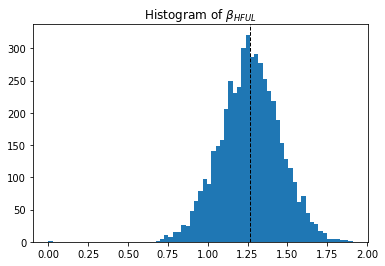

In [6]:
plt.hist(estimates[:, 2], bins=int(np.ceil(np.sqrt(estimates.shape[0]))))
plt.title(r"Histogram of $\beta_{HFUL}$")
plt.axvline(estimates[:, 2].mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()